In [19]:
%run classes.ipynb
%run training.ipynb
# Testing cell
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import time
X_test = readCSet()
# shape of X_test is objects x layers x width x height
def test(windowSize, windowAdvance, clf, oc1, e1):
    twindowSize = windowSize
    twindowAdvance = windowAdvance

    ab = blockAccumulator(twindowSize, twindowAdvance)

    # X_test = readRawHouseImages()
    testObjects = np.moveaxis(X_test, 1, 0)
    # shape of testObjects is layers x objects x width x height
    maskB = makeMaskB(X_test, emptyRatioB)
    bgrb = backgroundRemover(maskB)

    testx = []
    predictions = []
    times = []
    letsPrint = False
    for i in range(0, len(testObjects)):
        image = testObjects[i]
        # Start of timing
        start_time = time.time()
        noback = bgrb.removeBackground(image)
        # segments = makesegments(noback, hsegments)
        segments = noback
        segmentblocks = ab.next(segments)
        if(segmentblocks is False):
            continue
        # why is the blockAccumulator summing across one axis? Is it flattening all layers? That seems wrong...
        ocvals = oc1.calculate(segmentblocks)
        hists = e1.encode(ocvals)
        pred = clf.predict_proba(hists)[:,1]
        times.append(time.time() - start_time)
        # End of timing
        testx.append(hists)
        predictions.append(pred)
        # %run classes.ipynb

    # investigate accuracy etc here. Potentially batch it based on layer
    labelRanges = [(i, i+twindowSize) for i in range(0, bend-twindowSize+1, twindowAdvance)]
    y_test = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]
    # y_test = [getLabelsB(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,29)]
    ysvalue = []
    relevantTimes = []
    relevantPredictions = []
    relevantYTrues = []
    for index, o in enumerate(predictions):
        ysThatMayBeNan = np.array(y_test[index*25:(index+1)*25])
        predictionsOfInterest = o[~np.isnan(ysThatMayBeNan)]
        nonNanYs = ysThatMayBeNan[~np.isnan(ysThatMayBeNan)]
        if len(nonNanYs) > 0 and np.unique(nonNanYs).size > 1:
            ysvalue.append(roc_auc_score(nonNanYs, predictionsOfInterest))
            relevantTimes.append(times[index])
            relevantPredictions.append(predictionsOfInterest)
            relevantYTrues.append(nonNanYs)
        
    # plt.plot([s for (s, e) in labelRanges], ysvalue, 'o-', markersize=2)
    # print(np.mean(ysvalue))
    # plt.ylabel("ROC-AUC")
    # plt.xlabel("Window start layer")
    # plt.axline((0, 0.975), (1, 0.975), color='g', linestyle='--')
    # plt.axline((0, 0.5), (1, 0.5), color='r', linestyle='--')
    # plt.figure()
    # plt.plot([s for (s, e) in labelRanges], times, 'o-', markersize=2)
    # plt.axline((0, 11.82), (1, 11.82), color='g', linestyle='--')
    # # plt.axline((0, 10.75), (1, 10.75), color='g', linestyle='--')
    # plt.ylabel("Execution time (s)")
    # plt.xlabel("Window start layer")
    return ysvalue, relevantTimes, relevantPredictions, relevantYTrues

In [20]:
# WA is (50% of WS), while ensuring 5 samples
settings = [(5, 3),
            (15, 8),
            (25, 13),
            (50, 25),
            (75, 30),
            (105, 52),
            #(125, 15),
            #(150, 15),
            #(175, 20),
            #(200, 10),
            (212, 13)]

zs = [1,2,3]
ndist = [3,5,7]
k = [3,5,7]
nobins = [10,20,40]


In [21]:
results = []
for (windowSize, windowAdvance) in settings:
    clf, oc1, e1, score = train(windowSize, windowAdvance, zs, ndist, k, nobins)
    results.append(test(windowSize, windowAdvance, clf, oc1, e1))
    print(results[-1][0])
# Update the green line, should be the batch processing result for the new dataset
# Remove the outliers from the dataset (the ones above like 10% porosity)
# Write pseudokode for friday
# Run the economic evaluation first, then iterate on results...
ws = [w for (w, a) in settings]

[0.7666666666666667, 0.6973684210526315, 0.6893939393939393, 0.78, 0.65, 0.8452380952380951, 0.885, 0.8596491228070176, 0.7105263157894737, 0.76, 0.8771929824561404, 0.46, 0.7982456140350878, 0.8055555555555556, 0.6825396825396826, 0.8174603174603176, 0.6798245614035088, 0.869047619047619, 0.6754385964912281, 0.7719298245614036, 0.7261904761904762, 0.6801470588235294, 0.7573529411764706, 0.6349206349206349, 0.7324561403508772, 0.7017543859649122, 0.7426470588235294, 0.6706349206349207, 0.7017543859649122, 0.6359649122807017, 0.5454545454545455, 0.75, 0.7324561403508772, 0.8308823529411765, 0.7291666666666666, 0.7817460317460319, 0.5964912280701754, 0.5514705882352942, 0.7301587301587302, 0.5772058823529411, 0.7352941176470588, 0.7456140350877192, 0.7149122807017544, 0.665, 0.8015873015873017, 0.5451388888888888, 0.6360294117647058, 0.5789473684210525, 0.7236842105263157, 0.4920634920634921, 0.6838235294117646, 0.738970588235294, 0.7301587301587301, 0.6710526315789473, 0.78, 0.742063492

In [22]:
fpr = []
fnr = []

for (_, _, pred, true) in results:
    pred = np.where(np.concatenate(pred) < 0.5, 0, 1).astype(bool)
    true = np.concatenate(true).astype(bool)
    fpr.append(
        (np.sum(pred & ~true)) / np.sum(~true)
    )
    fnr.append(
        (np.sum(~pred & true)) / np.sum(true)
    )


(0.45, 1.0)

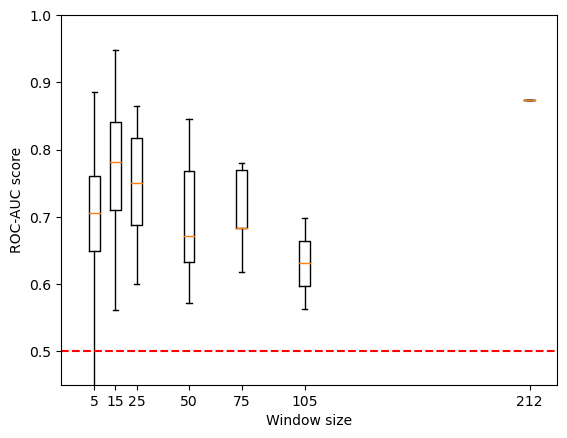

In [23]:
all = [np.array(s) for (s, t, _, _) in results]
# scores = [np.average(s) for (s, t) in results]
# median = [np.median(s) for (s, t) in results]
# minscore = [np.average(s) - np.std(s) for (s, t) in results]
# maxscore = [np.average(s) + np.std(s) for (s, t) in results]
# times = [t for (s, t) in results]
# plt.plot(ws, scores, 'o-', markersize=2)
# plt.plot(ws, minscore, 'o-', markersize=2)
# plt.plot(ws, maxscore, 'o-', markersize=2)
plt.boxplot(all, positions=ws, widths=5, showfliers=False, whis=[0, 100])
plt.xlabel("Window size")
plt.ylabel("ROC-AUC score")
plt.axline((0, 0.5), (1, 0.5), color='r', linestyle='--')
plt.gca().set_ylim(0.45, 1)

# plt.plot(ws, median, 'o-', markersize=2)
# plt.xscale('log')

In [24]:
import matplotlib as mpl
scrapRatio = [0.1, 0.2, 0.3, 0.4]
Cins = [0.1, 0.2, 0.3, 0.4]
CR = (np.array(ws) + 13) / 225
fpr
fnr
# Each fpr, tpr, cr pair can make it's own plot. Let's draw all of them?
for i in range(0, len(CR)):
    res = np.empty(shape=(len(scrapRatio), len(Cins)))
    for j in range (0, len(Cins)):
        for k in range(0, len(scrapRatio)):
            res[k, j] = getCost(scrapRatio[k], Cins[j], fpr[i], fnr[i], min(CR[i], 1))
    plt.matshow(res, interpolation='none', origin='lower', cmap=mpl.colormaps['RdBu'], vmin=0.8, vmax=1.2)
    plt.title("Window size: " + str(ws[i]))
    for x in range(len(Cins)):
        for y in range(len(scrapRatio)):
            c = res[y,x]
            plt.text(x, y, f"{c:.3f}", va='center', ha='center')
    # Inspection cost on x-axis
    plt.gca().xaxis.tick_bottom()

    plt.xticks(ticks=range(0, len(Cins)), labels=Cins)
    plt.xlabel("Inspection cost ratio")
    # scrap ratio on y axis
    plt.yticks(ticks=range(0, len(scrapRatio)), labels=scrapRatio)
    plt.ylabel("Scrap ratio")
    plt.figure()
    # print(res)
# 0.5, 0.5 -> 0.82
# 0.1, 0.1 -> 1.10
# 0.5, 0.1 -> 0.90
# 0.1, 0.5 -> 1.05

Exception: DOn't use this, currently broken

<Figure size 640x480 with 0 Axes>

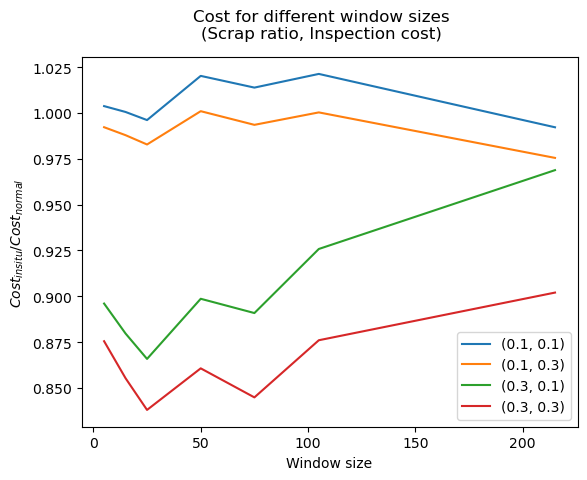

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
scrapRatio = [0.1, 0.4]
Cins = [0.1, 0.4]
CR = (np.array(ws) + 13) / 225
fpr
fnr
# Each fpr, tpr, cr pair can make it's own plot. Let's draw all of them?
res = np.empty(shape=(len(scrapRatio), len(Cins), len(CR)))
for i in range(0, len(CR)):
    for j in range (0, len(Cins)):
        for k in range(0, len(scrapRatio)):
            res[k, j, i] = getCost(scrapRatio[k], Cins[j], fpr[i], fnr[i], min(CR[i], 1))

plt.suptitle("Cost for different window sizes\n(Scrap ratio, Inspection cost)")
plt.plot(ws, res[0,0,:], label="(0.1, 0.1)")
plt.plot(ws, res[0,1,:], label="(0.1, 0.3)")
plt.plot(ws, res[1,0,:], label="(0.3, 0.1)")
plt.plot(ws, res[1,1,:], label="(0.3, 0.3)")
plt.legend()
plt.xlabel("Window size")
plt.ylabel("$Cost_{insitu} / Cost_{normal}$")
plt.figure()
    # print(res)
# 0.5, 0.5 -> 0.82
# 0.1, 0.1 -> 1.10
# 0.5, 0.1 -> 0.90
# 0.1, 0.5 -> 1.05
# Make four lines: 0.1, 0.3
# Vilka poänger vill vi kommunicera?
# - Finns en tradeoff mellan bra och snabbt resultat
# - Visa hur scrap ratio och inspection cost påverkar

In [ ]:
def getCost(scrapRatio, C_inspection_ratio, fpr, fnr, CR):
    C_scrap = CR * (C_material + C_proc) + C_pre + C_post - C_inspection
    C_net2 = (C_net - C_inspection) * (1 + C_inspection_ratio)
    first = (1-scrapRatio)* ((1-fpr) * C_net2 + fpr*C_scrap)
    second = scrapRatio * (fnr * C_net2 + (1-fnr) * C_scrap)
    C_part_insitu = (first + second) / ((1 - scrapRatio)*(1-fpr))
    return C_part_insitu / (C_net2 / (1 - scrapRatio))

Text(0, 0.5, 'Execution time (s)')

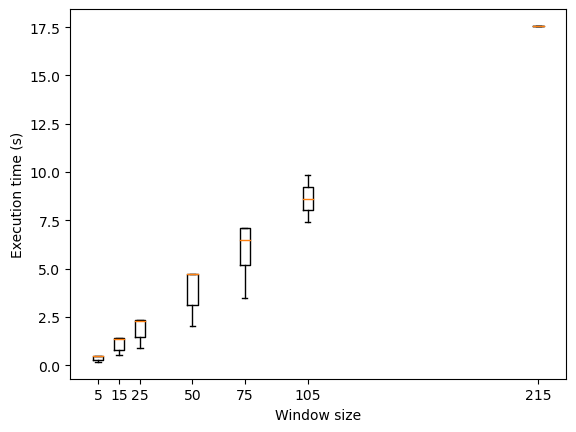

In [ ]:
allts = [np.array(t) for (s, t, _, _) in results]
# scores = [np.average(s) for (s, t) in results]
# median = [np.median(s) for (s, t) in results]
# minscore = [np.average(s) - np.std(s) for (s, t) in results]
# maxscore = [np.average(s) + np.std(s) for (s, t) in results]
# times = [t for (s, t) in results]
# plt.plot(ws, scores, 'o-', markersize=2)
# plt.plot(ws, minscore, 'o-', markersize=2)
# plt.plot(ws, maxscore, 'o-', markersize=2)
plt.boxplot(allts, positions=ws, widths=5, showfliers=False, whis=[0, 100])
plt.xlabel("Window size")
plt.ylabel("Execution time (s)")

# plt.plot(ws, median, 'o-', markersize=2)
# plt.xscale('log')

In [ ]:
y_test = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]

xtrain_real =  np.array(allTrainingHists)
ytrain_real =  np.array(ytrainboth)
(x,y,z) = np.shape(testx)
xtest_real = np.reshape(testx, ((x*y,z)))
ytest_real = np.array(y_test)


print(np.shape(xtrain_real))
print(np.shape(ytrain_real))
print(np.shape(xtest_real))
print(np.shape(ytest_real))

NameError: name 'testx' is not defined

0.28
0.28
[(0, 75), (25, 100), (50, 125), (75, 150), (100, 175), (125, 200), (150, 225)]


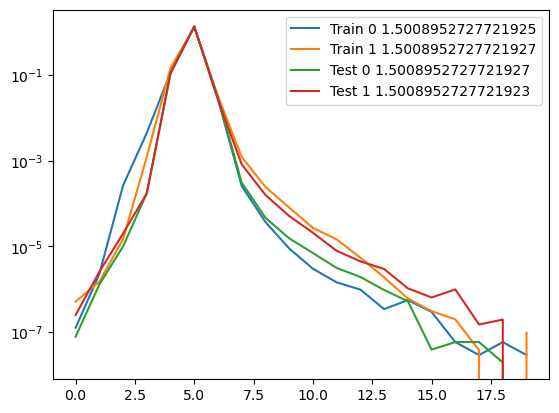

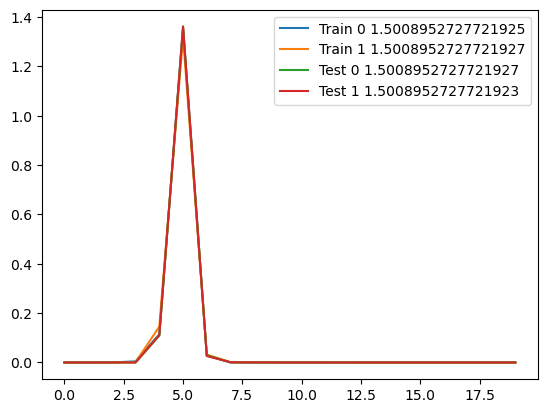

In [ ]:
# Draw the average histogram for each label in the training set
train0 = np.mean(xtrain_real[ytrain_real == 0], axis=0)
train1 = np.mean(xtrain_real[ytrain_real == 1], axis=0)
# Draw the average histogram for each label in the testing set
test0 = np.mean(xtest_real[ytest_real == 0], axis=0)
test1 = np.mean(xtest_real[ytest_real == 1], axis=0)
plt.plot(range(0, len(train0)), train0, label="Train 0 " + str(np.sum(train0)))
plt.plot(range(0, len(train1)), train1, label="Train 1 " + str(np.sum(train1)))
plt.plot(range(0, len(test0)), test0, label="Test 0 " + str(np.sum(test0)))
plt.plot(range(0, len(test1)), test1, label="Test 1 " + str(np.sum(test1)))
plt.legend()
plt.yscale('log')
plt.figure()
print(np.average(ytest_real))
print(np.average(y_test))
print(labelRanges)